In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage import label, find_objects, binary_erosion
from skimage.color import rgb2lab, lab2rgb
from skimage.util import img_as_float
from sklearn.cluster import MeanShift, estimate_bandwidth, KMeans, AgglomerativeClustering
from collections import Counter

In [2]:
# -----------------------------------------------------------------------------
# Utility Functions
# -----------------------------------------------------------------------------
def display_image(image_array, title="Image", size=(6,6)):
    """
    Display a given image array (NumPy array) with a title.
    For images with transparency, a white background is used.
    """
    if image_array.shape[-1] == 4:
        rgb = image_array[..., :3].copy()
        alpha = image_array[..., 3]
        rgb[alpha==0] = [255, 255, 255]
        img_to_show = rgb
    else:
        img_to_show = image_array
    plt.figure(figsize=size)
    plt.imshow(img_to_show)
    plt.title(title)
    plt.axis('off')
    plt.show()

def get_unique_colors(image):
    """
    Return a list of unique RGB colors in the input image.
    If the image is already flattened (i.e. shape (N,3)), it returns unique rows.
    """
    if image.ndim == 2:
        arr = image
    else:
        arr = image.reshape(-1, image.shape[2])
    return np.unique(arr, axis=0)


def display_palette(palette, title="Palette"):
    """
    Displays a list of RGB colors as swatches in a single row.
    """
    if len(palette) == 0:
        print(f"No colors to display for {title}.")
        return
    swatch_height = 50
    swatch_width = 50
    n_colors = len(palette)
    swatches = np.zeros((swatch_height, swatch_width * n_colors, 3), dtype=np.uint8)
    for i, color in enumerate(palette):
        swatches[:, i*swatch_width:(i+1)*swatch_width, :] = np.array(color, dtype=np.uint8)
    plt.figure(figsize=(max(n_colors, 8), 2))
    plt.imshow(swatches)
    plt.title(title)
    plt.axis('off')
    plt.show()

def compute_circumference(mask):
    """
    Compute the perimeter of a connected component using binary erosion.
    """
    eroded = binary_erosion(mask, structure=np.ones((3,3)))
    edge_mask = mask & ~eroded
    return np.sum(edge_mask)

def get_component_image(element, has_alpha=False):
    """
    Given an element (with keys "bbox", "mask", "color"), create an image of its bounding box
    with the component painted in its color.
    """
    y_min, y_max, x_min, x_max = element["bbox"]
    height = y_max - y_min
    width = x_max - x_min
    if has_alpha:
        comp_img = np.dstack((
            255*np.ones((height, width), dtype=np.uint8),
            255*np.ones((height, width), dtype=np.uint8),
            255*np.ones((height, width), dtype=np.uint8),
            np.zeros((height, width), dtype=np.uint8)
        ))
        comp_img[element["mask"]] = list(element["color"]) + [255]
    else:
        comp_img = 255 * np.ones((height, width, 3), dtype=np.uint8)
        comp_img[element["mask"]] = element["color"]
    return comp_img

def display_components_grid(layers_dict, has_alpha=False):
    """
    Display a grid where each row corresponds to a layer and each cell shows the component image.
    """
    layer_numbers = sorted(layers_dict.keys())
    if not layer_numbers:
        print("No layers to display.")
        return

    max_cols = max(len(layers_dict[layer]) for layer in layer_numbers)

    fig, axes = plt.subplots(nrows=len(layer_numbers), ncols=max_cols, figsize=(max_cols*3, len(layer_numbers)*3))
    if len(layer_numbers) == 1:
        axes = np.expand_dims(axes, axis=0)
    if max_cols == 1:
        axes = np.expand_dims(axes, axis=1)

    for row_idx, layer in enumerate(layer_numbers):
        components = layers_dict[layer]
        for col_idx in range(max_cols):
            ax = axes[row_idx, col_idx]
            if col_idx < len(components):
                comp_img = get_component_image(components[col_idx], has_alpha=has_alpha)
                ax.imshow(comp_img)
                ax.set_title(f"ID {components[col_idx]['id']}")
            else:
                ax.axis('off')
            if col_idx == 0:
                ax.set_ylabel(f"Layer {layer}", rotation=0, size='large', labelpad=40)
            ax.axis('off')
    plt.tight_layout()
    plt.show()

# -----------------------------------------------------------------------------
# NEW: Helper function to compute Lab distance for two RGB colors
# -----------------------------------------------------------------------------
def lab_distance(rgb1, rgb2):
    """
    Convert two RGB colors (0-255) to Lab (after scaling to [0,1]) and return the Euclidean distance.
    """
    # Convert to float and scale to [0,1]
    rgb1_arr = np.array([[list(rgb1)]], dtype=np.float64) / 255.0
    rgb2_arr = np.array([[list(rgb2)]], dtype=np.float64) / 255.0
    lab1 = rgb2lab(rgb1_arr)[0,0,:]
    lab2 = rgb2lab(rgb2_arr)[0,0,:]
    return np.linalg.norm(lab1 - lab2)

# -----------------------------------------------------------------------------
# Modified: Hierarchical clustering (reduce_palette_to_n_colors) using Lab space
# -----------------------------------------------------------------------------
def reduce_palette_to_n_colors(full_palette, target_n):
    """
    Use hierarchical clustering (AgglomerativeClustering) in Lab space to combine
    similar colors in 'full_palette' until 'target_n' clusters remain.
    Returns a new list of palette colors (RGB tuples).
    """
    if target_n >= len(full_palette):
        return list(full_palette)

    # Convert the palette from RGB to Lab (scale to [0,1] first)
    lab_palette = []
    for color in full_palette:
        lab_val = rgb2lab(np.array([[list(color)]], dtype=np.float64)/255.0)[0,0,:]
        lab_palette.append(lab_val)
    X = np.array(lab_palette, dtype=np.float64)

    clustering = AgglomerativeClustering(n_clusters=target_n, metric='euclidean', linkage='average')
    labels = clustering.fit_predict(X)

    new_colors_lab = []
    for cluster_id in range(target_n):
        cluster_members = X[labels == cluster_id]
        mean_lab = cluster_members.mean(axis=0)
        new_colors_lab.append(mean_lab)

    # Convert new colors from Lab back to RGB
    new_colors_rgb = []
    for lab_val in new_colors_lab:
        rgb_val = lab2rgb(np.array([[lab_val]]))
        rgb_val = (np.clip(rgb_val, 0, 1) * 255).astype(np.uint8)[0,0,:]
        new_colors_rgb.append(tuple(rgb_val))
    return new_colors_rgb

# -----------------------------------------------------------------------------
# Modified: find_nearest_color uses Lab distance for final recolor
# -----------------------------------------------------------------------------
def find_nearest_color(px, palette):
    best_c = None
    best_d = float('inf')
    for c in palette:
        d = lab_distance(px, c)
        if d < best_d:
            best_d = d
            best_c = c
    return best_c

# -----------------------------------------------------------------------------
# Modified: Merge palettes using Lab space for near-duplicate removal
# -----------------------------------------------------------------------------
def merge_palettes_remove_duplicates(palette1, palette2, threshold=5.0):
    """
    Merge two RGB palettes, removing near-duplicate colors within
    a certain distance threshold in Lab space.
    Returns a list of unique color tuples (R, G, B).
    """
    merged = list(palette1) + list(palette2)  # combine
    unique_colors = []
    for color in merged:
        if not unique_colors:
            unique_colors.append(color)
        else:
            is_duplicate = False
            for uc in unique_colors:
                if lab_distance(color, uc) < threshold:
                    is_duplicate = True
                    break
            if not is_duplicate:
                unique_colors.append(color)
    return unique_colors

# -----------------------------------------------------------------------------
# Modified: Recluster palette using K-Means in Lab space
# -----------------------------------------------------------------------------
def recluster_palette(color_list, final_k=10):
    """
    Re-run K-Means on the combined palette in Lab space
    to get exactly final_k cluster centers.
    Returns a list of RGB tuples.
    """
    X = []
    for color in color_list:
        lab_val = rgb2lab(np.array([[list(color)]], dtype=np.float64)/255.0)[0,0,:]
        X.append(lab_val)
    X = np.array(X, dtype=float)
    kmeans = KMeans(n_clusters=final_k, random_state=42)
    kmeans.fit(X)
    new_centers_lab = kmeans.cluster_centers_
    new_centers_rgb = []
    for lab_val in new_centers_lab:
        rgb_val = lab2rgb(np.array([[lab_val]]))
        rgb_val = (np.clip(rgb_val, 0, 1) * 255).astype(np.uint8)[0,0,:]
        new_centers_rgb.append(tuple(rgb_val))
    return new_centers_rgb

# -----------------------------------------------------------------------------
# Modified: find_nearest_palette_color uses Lab distance
# -----------------------------------------------------------------------------
def find_nearest_palette_color(px, palette):
    # Convert pixel to Lab
    lab_px = rgb2lab(np.array([[list(px)]], dtype=np.float64)/255.0)[0,0,:]
    best_color = None
    best_dist = float('inf')
    for c in palette:
        lab_c = rgb2lab(np.array([[list(c)]], dtype=np.float64)/255.0)[0,0,:]
        dist = np.linalg.norm(lab_px - lab_c)
        if dist < best_dist:
            best_dist = dist
            best_color = c
    return best_color

# -----------------------------------------------------------------------------
# Modified: Recolor image to palette using vectorized Lab distance
# -----------------------------------------------------------------------------
from scipy.spatial import distance
def recolor_image_to_palette(rgb_img, palette):
    """
    Reassign each pixel in 'rgb_img' to the closest color in 'palette',
    using distances in Lab space. Returns a new color-quantized NumPy array (H, W, 3).
    """
    H, W = rgb_img.shape[:2]
    # Convert image to float in [0,1] and then to Lab
    img_float = rgb_img.astype(np.float64) / 255.0
    lab_img = rgb2lab(img_float)
    # Convert palette to Lab
    palette_array = np.array(palette, dtype=np.float64) / 255.0
    palette_lab = rgb2lab(palette_array.reshape(1, -1, 3)).reshape(-1, 3)
    # Reshape lab image to (H*W, 3)
    lab_pixels = lab_img.reshape(-1, 3)
    # Compute distances from each pixel to each palette color in Lab space
    dists = distance.cdist(lab_pixels, palette_lab, metric='euclidean')
    nearest_indices = np.argmin(dists, axis=1)
    new_img = np.array(palette, dtype=np.uint8)[nearest_indices]
    return new_img.reshape(H, W, 3)


In [3]:
# -----------------------------------------------------------------------------
# Step 1: File Input
# -----------------------------------------------------------------------------
try:
    path_input = input("Enter file path to your image (or press Enter to upload): ").strip()
except:
    path_input = ""

if path_input:
    filename = path_input
    img = Image.open(filename)
else:
    print("Please upload your image file.")
    from google.colab import files
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]
    img = Image.open(filename)


Enter file path to your image (or press Enter to upload): 
Please upload your image file.


Saving totoro.png to totoro.png


In [ ]:
# -----------------------------------------------------------------------------
# Step 2: Check alpha & prepare
# -----------------------------------------------------------------------------
has_alpha = (img.mode in ('RGBA', 'LA'))
if has_alpha:
    img_np = np.array(img)
    rgb_img = img_np[..., :3]
    alpha_channel = img_np[..., 3]
    fg_mask = alpha_channel > 0
    display_img = rgb_img.copy()
    display_img[~fg_mask] = [255, 255, 255]
else:
    img_np = np.array(img.convert('RGB'))
    rgb_img = img_np
    fg_mask = np.ones(rgb_img.shape[:2], dtype=bool)
    display_img = rgb_img

height, width = rgb_img.shape[:2]
display_image(display_img, title="Original Image")

In [ ]:
# -----------------------------------------------------------------------------
# Step 3: Downscale, Convert to Lab, and MeanShift Clustering
# -----------------------------------------------------------------------------
from skimage.transform import resize
from scipy.spatial import distance

# 1) Downscale the image first (e.g., 20% of the original size)
scale_factor = 0.2
H, W = rgb_img.shape[:2]
newH, newW = int(H * scale_factor), int(W * scale_factor)
shrunken_img = resize(rgb_img, (newH, newW), anti_aliasing=True, preserve_range=True).astype(np.uint8)
display_image(shrunken_img, title="Shrunken Image")

# 2) Convert the downscaled image to Lab and reshape for clustering
lab_small = rgb2lab(shrunken_img.astype(np.float64)/255.0)
pixels_lab_small = lab_small.reshape((-1, 3))

# 3) Estimate bandwidth on a random sample of the SMALL image's pixels
sample_fraction = 0.5
sample_size = int(sample_fraction * pixels_lab_small.shape[0])
sample_indices = np.random.choice(pixels_lab_small.shape[0], sample_size, replace=False)
sample_data_small = pixels_lab_small[sample_indices]

print("Estimating bandwidth for MeanShift on the shrunken image...")
bandwidth = estimate_bandwidth(sample_data_small, quantile=0.1, n_samples=len(sample_data_small))
print(f"Estimated bandwidth = {bandwidth:.2f}")

print("Running MeanShift on the shrunken image...")
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(pixels_lab_small)

labels_small = ms.labels_
cluster_centers_ms = ms.cluster_centers_
unique_labels = np.unique(labels_small)
print(f"MeanShift found {len(unique_labels)} clusters total on the shrunken image.")

# 4) Apply those cluster centers to the FULL image in Lab space
lab_full = rgb2lab(rgb_img.astype(np.float64)/255.0)
pixels_lab_full = lab_full.reshape((-1, 3))
dists = distance.cdist(pixels_lab_full, cluster_centers_ms)
closest_centers = np.argmin(dists, axis=1)
new_lab_img = cluster_centers_ms[closest_centers].reshape(lab_full.shape)
new_rgb_img = lab2rgb(new_lab_img)
new_rgb_img_255 = (np.clip(new_rgb_img, 0, 1) * 255).astype(np.uint8)

if has_alpha:
    mean_shift_img = np.dstack((new_rgb_img_255, alpha_channel))
    display_ms = new_rgb_img_255.copy()
    display_ms[~fg_mask] = [255, 255, 255]
else:
    mean_shift_img = new_rgb_img_255
    display_ms = mean_shift_img

display_image(display_ms, title="MeanShift Result (Full Res)")

# 5) Extract the unique palette of colors found
ms_unique_colors = get_unique_colors(new_rgb_img_255[fg_mask].reshape(-1, 3))
ms_palette = [tuple(c) for c in ms_unique_colors]
print(f"MeanShift palette has {len(ms_palette)} colors.")
display_palette(ms_palette, title="MeanShift Palette")


In [ ]:
# -----------------------------------------------------------------------------
# Elbow Method: Determine a good 'k' by plotting inertia vs. k
# -----------------------------------------------------------------------------
k_values = range(2, 11)
inertias = []
pixels_lab = rgb2lab(display_img.astype(np.float64)/255.0).reshape((-1, 3))

for k in k_values:
    kmeans_temp = KMeans(n_clusters=k, random_state=42)
    kmeans_temp.fit(pixels_lab)
    inertias.append(kmeans_temp.inertia_)

plt.figure(figsize=(6,4))
plt.plot(k_values, inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("K-Means Elbow Plot")
plt.show()

In [ ]:
# -----------------------------------------------------------------------------
# Choose the number of clusters (e.g. after examining the elbow plot)
# -----------------------------------------------------------------------------
k = 6  # Change this as desired
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(pixels_lab)
labels_km = kmeans.labels_
cluster_centers_km = kmeans.cluster_centers_
cluster_centers_rgb = lab2rgb(cluster_centers_km.reshape(1, -1, 3)).reshape(-1, 3)

new_lab_img = cluster_centers_km[labels_km].reshape(lab_full.shape)
new_rgb_img = lab2rgb(new_lab_img)
new_rgb_img_255 = (np.clip(new_rgb_img, 0, 1) * 255).astype(np.uint8)

if has_alpha:
    kmeans_img = np.dstack((new_rgb_img_255, alpha_channel))
    display_km = new_rgb_img_255.copy()
    display_km[~fg_mask] = [255, 255, 255]
else:
    kmeans_img = new_rgb_img_255
    display_km = kmeans_img

display_image(display_km, title="K-Means Result")
km_palette = (cluster_centers_rgb * 255).astype(np.uint8).tolist()
print(f"K-Means palette has {len(km_palette)} colors.")
display_palette(km_palette, title="K-Means Palette")


In [8]:
def optimized_recolor_image_to_palette(rgb_img, palette):
    """
    Reassign each pixel in 'rgb_img' to the closest color in 'palette' using a vectorized
    approach in Lab space.
    """
    H, W = rgb_img.shape[:2]
    # Convert the full image to Lab space (scale to [0,1])
    img_float = rgb_img.astype(np.float64) / 255.0
    lab_img = rgb2lab(img_float)
    lab_pixels = lab_img.reshape(-1, 3)

    # Precompute Lab values for the palette
    palette = np.array(palette, dtype=np.uint8)
    palette_float = palette.astype(np.float64) / 255.0
    # Reshape to (1, num_colors, 3) then convert to Lab and reshape to (num_colors, 3)
    palette_lab = rgb2lab(palette_float.reshape(1, -1, 3)).reshape(-1, 3)

    # Compute distances from each pixel to each palette color
    dists = distance.cdist(lab_pixels, palette_lab, metric='euclidean')
    nearest_indices = np.argmin(dists, axis=1)

    # Map pixels to their nearest palette color
    new_img = palette[nearest_indices].reshape(H, W, 3)
    return new_img

How many final colors do you want? 6
Merging the MeanShift palette from 11 to 6 colors...
Palette is now 6 colors. Mapping image to these colors...


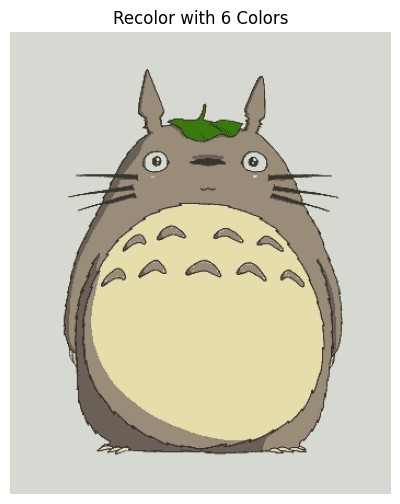

After forced color reduction, we have 6 colors.



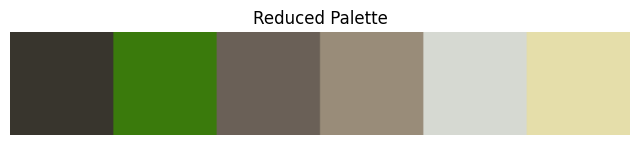

In [9]:
# -----------------------------------------------------------------------------
# Step 4: Reduce MeanShift palette to user-defined # of colors (Improved)
# -----------------------------------------------------------------------------
user_n = int(input("How many final colors do you want? "))
print(f"Merging the MeanShift palette from {len(ms_palette)} to {user_n} colors...")
final_palette = reduce_palette_to_n_colors(ms_palette, user_n)
print(f"Palette is now {len(final_palette)} colors. Mapping image to these colors...")

# Recolor the final image by assigning each pixel to the nearest color (using Lab distance)
final_array = mean_shift_img[..., :3].copy() if has_alpha else mean_shift_img.copy()

final_array = optimized_recolor_image_to_palette(mean_shift_img[..., :3] if has_alpha else mean_shift_img, final_palette)

if has_alpha:
    final_img_np = np.dstack((final_array, alpha_channel))
    display_new = final_array.copy()
    display_new[~fg_mask] = [255, 255, 255]
else:
    final_img_np = final_array
    display_new = final_img_np

display_image(display_new, title=f"Recolor with {user_n} Colors")
palette_after_reduce = get_unique_colors(display_new[fg_mask].reshape(-1, 3))
palette_after_reduce_tuples = [tuple(c) for c in palette_after_reduce]
print(f"After forced color reduction, we have {len(palette_after_reduce_tuples)} colors.\n")
display_palette(palette_after_reduce_tuples, title="Reduced Palette")


In [ ]:
# -----------------------------------------------------------------------------
# Merge palettes and re-cluster using Lab distances
# -----------------------------------------------------------------------------
combined_palette = merge_palettes_remove_duplicates(km_palette, palette_after_reduce_tuples, threshold=5.0)
print(f"Combined palette length (before re-clustering) = {len(combined_palette)}")
desired_k = 6  # Change as desired
final_palette = recluster_palette(combined_palette, final_k=desired_k)
print(f"Final palette length (after re-clustering to {desired_k}) = {len(final_palette)}")
final_quantized_img = recolor_image_to_palette(rgb_img, final_palette)
display_image(final_quantized_img, title="Combined K-Means + MeanShift Palette")
display_palette(final_palette, title="Combined Palette")


In [ ]:
# --- New Colab cell for "cartoonizing" cleanup ---
from scipy.ndimage import label
from collections import Counter

def remove_small_splotches_colorwise(img, min_size=1):
    """
    For each unique color in 'img', find connected components.
    If a connected component's area is smaller than 'min_size',
    reassign its pixels to the most frequent neighboring color (8-connected).
    """
    cleaned = img.copy()
    unique_colors = np.unique(cleaned.reshape(-1, 3), axis=0)
    def get_neighbors(r, c, h, w):
        neighbors = []
        for nr in range(r-1, r+2):
            for nc in range(c-1, c+2):
                if 0 <= nr < h and 0 <= nc < w and not (nr == r and nc == c):
                    neighbors.append((nr, nc))
        return neighbors
    for color in unique_colors:
        mask = np.all(cleaned == color, axis=-1)
        labeled_mask, num_labels = label(mask, structure=np.ones((3,3)))
        for label_id in range(1, num_labels + 1):
            coords = np.argwhere(labeled_mask == label_id)
            size = coords.shape[0]
            if size < min_size:
                for (r, c) in coords:
                    neighbors_rc = get_neighbors(r, c, mask.shape[0], mask.shape[1])
                    neighbor_colors = []
                    for (nr, nc) in neighbors_rc:
                        neighbor_colors.append(tuple(cleaned[nr, nc]))
                    if neighbor_colors:
                        most_common_color = Counter(neighbor_colors).most_common(1)[0][0]
                        cleaned[r, c] = most_common_color
    return cleaned

percent_size = 0
min_size_threshold = percent_size*(width*height) / (100 * 100)
cartoonized_img = remove_small_splotches_colorwise(final_quantized_img, min_size=min_size_threshold)
display_image(cartoonized_img, title=f"Cartoonized (min_size={min_size_threshold})")

In [20]:
image_for_cc = cartoonized_img.copy()

In [ ]:
from ipywidgets import interact, IntSlider, FloatSlider
from scipy.ndimage import label, find_objects, binary_erosion
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import math

# ---------------- Helper Functions ----------------

def get_global_mask(elem, full_shape):
    """Create a full-size binary mask for an element using its bbox and local mask."""
    global_mask = np.zeros(full_shape, dtype=bool)
    y_min, y_max, x_min, x_max = elem["bbox"]
    global_mask[y_min:y_max, x_min:x_max] = elem["mask"]
    return global_mask

def is_element_inside(inner, outer, full_shape, threshold=0.95):
    """
    Determine if 'inner' is mostly inside 'outer' using pixel-level masks.
    Returns True if at least 'threshold' fraction of inner's pixels are contained in outer.
    """
    y1, y2, x1, x2 = inner["bbox"]
    oy1, oy2, ox1, ox2 = outer["bbox"]
    if oy1 > y1 or oy2 < y2 or ox1 > x1 or ox2 < x2:
        return False
    inner_global = get_global_mask(inner, full_shape)
    outer_global = get_global_mask(outer, full_shape)
    inner_region = inner_global[y1:y2, x1:x2]
    outer_region = outer_global[y1:y2, x1:x2]
    if inner_region.sum() == 0:
        return False
    overlap = np.logical_and(inner_region, outer_region).sum()
    return (overlap / inner_region.sum()) >= threshold

def is_outline(elem, fill_ratio_thresh=0.1, max_outline_area=20):
    """
    Determine if an element appears to be merely an outline.
    Uses binary erosion on the element’s mask; if erosion removes all pixels
    (i.e. the mask is only 1-pixel thick) and the element's area is below
    max_outline_area, then if its fill ratio (area / bbox area) is below fill_ratio_thresh,
    the element is considered an outline.
    """
    eroded = binary_erosion(elem["mask"], structure=np.ones((3,3)))
    if eroded.sum() == 0 and elem["area"] <= max_outline_area:
        y_min, y_max, x_min, x_max = elem["bbox"]
        bbox_area = (y_max - y_min) * (x_max - x_min)
        if bbox_area > 0:
            fill_ratio = elem["area"] / bbox_area
            if fill_ratio < fill_ratio_thresh:
                return True
    return False

def are_adjacent(elem1, elem2, dilation=1):
    """
    Determine if two elements are adjacent based on their bounding boxes.
    Their bboxes are dilated by 'dilation' pixels; if the dilated boxes overlap,
    the elements are considered adjacent.
    """
    y1, y2, x1, x2 = elem1["bbox"]
    y1o, y2o, x1o, x2o = elem2["bbox"]
    y1_d, y2_d = y1 - dilation, y2 + dilation
    x1_d, x2_d = x1 - dilation, x2 + dilation
    y1o_d, y2o_d = y1o - dilation, y2o + dilation
    x1o_d, x2o_d = x1o - dilation, x2o + dilation
    if x2_d < x1o_d or x2o_d < x1_d:
        return False
    if y2_d < y1o_d or y2o_d < y1_d:
        return False
    return True

# --------------- Union-Find Helpers ----------------
def uf_find(parent, i):
    if parent[i] != i:
        parent[i] = uf_find(parent, parent[i])
    return parent[i]

def uf_union(parent, rank, i, j):
    i_id = uf_find(parent, i)
    j_id = uf_find(parent, j)
    if i_id == j_id:
        return
    if rank[i_id] < rank[j_id]:
        parent[i_id] = j_id
    elif rank[i_id] > rank[j_id]:
        parent[j_id] = i_id
    else:
        parent[j_id] = i_id
        rank[i_id] += 1

# ---------------- Main Function with Dynamic Parameters ----------------

def run_layering(alpha=100, merge_threshold=3, fill_ratio_thresh=0.1, max_outline_area=20, adj_dilation=1):
    """
    Run the segmentation and layering pipeline with dynamic parameters.

    Parameters:
      alpha: Tuning constant for the priority formula.
      merge_threshold: Maximum difference between layer numbers (for same-color elements) to merge.
      fill_ratio_thresh: Fill ratio threshold for outline detection.
      max_outline_area: Maximum area for an element to be considered for outline removal.
      adj_dilation: Number of pixels to dilate bounding boxes when determining adjacency.
    """
    # Assumed globals:
    # - image_for_cc: RGB NumPy array (cartoonized image)
    # - final_palette: list of RGB tuples
    # - fg_mask: Boolean foreground mask
    # - compute_circumference(mask): function to compute perimeter
    # The final images are displayed in a grid.

    all_elements = []
    element_id = 0
    min_component_area = 10   # Skip very tiny segments

    # Step 1: Extract Connected Components for Each Color.
    for color in final_palette:
        mask = np.all(image_for_cc == color, axis=-1)
        mask &= fg_mask
        labeled_array, num_features = label(mask, structure=np.ones((3,3), dtype=int))
        slices = find_objects(labeled_array)

        for comp_index, sl in enumerate(slices, start=1):
            comp_mask = (labeled_array[sl] == comp_index)
            comp_size = np.sum(comp_mask)
            if comp_size < min_component_area:
                continue
            circumference = compute_circumference(comp_mask)
            bbox = (sl[0].start, sl[0].stop, sl[1].start, sl[1].stop)
            complexity = circumference / comp_size if comp_size > 0 else float('inf')

            elem = {
                "id": element_id,
                "color": color,
                "area": comp_size,
                "circumference": circumference,
                "bbox": bbox,
                "mask": comp_mask,  # Local coordinates within bbox.
                "enveloped_by": None,
                "layer": None,
                "complexity": complexity
            }
            all_elements.append(elem)
            element_id += 1

    all_elements = [e for e in all_elements if e["area"] >= min_component_area]

    # Step 2: Remove Outline-like Elements.
    all_elements = [e for e in all_elements if not is_outline(e, fill_ratio_thresh=fill_ratio_thresh, max_outline_area=max_outline_area)]

    # Step 3: Determine Engulfing Relationships.
    full_shape = image_for_cc.shape[:2]
    for elem in all_elements:
        candidate_parents = []
        for other in all_elements:
            if other["id"] == elem["id"]:
                continue
            if is_element_inside(elem, other, full_shape, threshold=0.95):
                candidate_parents.append(other)
        if candidate_parents:
            parent_elem = min(candidate_parents, key=lambda f: f["area"])
            elem["enveloped_by"] = parent_elem["id"]

    # Step 4: Compute Combined Priority.
    for e in all_elements:
        e["priority"] = e["complexity"] + alpha * (1.0 / e["area"])

    # Step 5: Preliminary Layer Assignment.
    sorted_elements = sorted(all_elements, key=lambda e: e["priority"], reverse=True)
    for i, e in enumerate(sorted_elements):
        e["layer"] = i + 1
    for e in sorted_elements:
        if e["enveloped_by"] is not None:
            parent_elem = next((p for p in sorted_elements if p["id"] == e["enveloped_by"]), None)
            if parent_elem and e["layer"] <= parent_elem["layer"]:
                e["layer"] = parent_elem["layer"] + 1

    # Step 6: Merge Adjacent Same-Color Elements (using union-find).
    n = len(sorted_elements)
    parent = list(range(n))
    rank = [0] * n
    color_to_indices = defaultdict(list)
    for idx, e in enumerate(sorted_elements):
        color_to_indices[e["color"]].append(idx)
    for color, indices in color_to_indices.items():
        for i in range(len(indices)):
            for j in range(i+1, len(indices)):
                idx_i = indices[i]
                idx_j = indices[j]
                if are_adjacent(sorted_elements[idx_i], sorted_elements[idx_j], dilation=adj_dilation):
                    uf_union(parent, rank, idx_i, idx_j)
    group_min_layer = {}
    for i in range(n):
        root = uf_find(parent, i)
        group_min_layer[root] = min(group_min_layer.get(root, float('inf')), sorted_elements[i]["layer"])
    for i in range(n):
        root = uf_find(parent, i)
        sorted_elements[i]["layer"] = group_min_layer[root]

    # Step 7: Merge Nearby Layers for the Same Color.
    merge_thresh = merge_threshold  # Merge if layers differ by merge_thresh or less.
    color_groups = defaultdict(list)
    for e in sorted_elements:
        color_groups[e["color"]].append(e)
    for color, group in color_groups.items():
        group.sort(key=lambda x: x["layer"])
        current_cluster = [group[0]]
        for e in group[1:]:
            if e["layer"] - current_cluster[-1]["layer"] <= merge_thresh:
                current_cluster.append(e)
            else:
                common_layer = min(x["layer"] for x in current_cluster)
                for x in current_cluster:
                    x["layer"] = common_layer
                current_cluster = [e]
        if current_cluster:
            common_layer = min(x["layer"] for x in current_cluster)
            for x in current_cluster:
                x["layer"] = common_layer

    # Step 8: Build and Display Layer Images in a Grid.
    layers_dict = defaultdict(list)
    for e in sorted_elements:
        layers_dict[e["layer"]].append(e)

    H, W = image_for_cc.shape[:2]
    layer_images = []
    for layer in sorted(layers_dict.keys()):
        layer_img = 255 * np.ones((H, W, 3), dtype=np.uint8)
        for elem in layers_dict[layer]:
            y_min, y_max, x_min, x_max = elem["bbox"]
            layer_img[y_min:y_max, x_min:x_max][elem["mask"]] = np.array(elem["color"], dtype=np.uint8)
        layer_images.append((layer, layer_img))

    n_layers = len(layer_images)
    ncols = min(n_layers, 5)
    nrows = math.ceil(n_layers / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))
    if nrows == 1 and ncols == 1:
        axes = np.array([[axes]])
    elif nrows == 1:
        axes = np.expand_dims(axes, axis=0)
    elif ncols == 1:
        axes = np.expand_dims(axes, axis=1)

    for idx, (layer, img) in enumerate(layer_images):
        row = idx // ncols
        col = idx % ncols
        axes[row, col].imshow(img)
        axes[row, col].set_title(f"Layer {layer}")
        axes[row, col].axis('off')
    for idx in range(n_layers, nrows * ncols):
        row = idx // ncols
        col = idx % ncols
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

# Create interactive sliders for dynamic parameters.
interact(run_layering,
         alpha=IntSlider(value=100, min=10, max=300, step=10, description="Alpha"),
         merge_threshold=IntSlider(value=3, min=1, max=100, step=1, description="Merge Thresh"),
         fill_ratio_thresh=FloatSlider(value=0.1, min=0.01, max=0.5, step=0.01, description="Fill Ratio Thresh"),
         max_outline_area=IntSlider(value=20, min=1, max=100, step=1, description="Max Outline Area"),
         adj_dilation=IntSlider(value=1, min=0, max=20, step=1, description="Adjacency Dilation"))
